In [1]:
import warnings

warnings.filterwarnings("ignore")

import os
from torch.utils import data
from dataset import*
from config import settings
from train_test import *
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from xgboost import XGBRegressor
from sklearn.model_selection import train_test_split
import time

In [2]:
transformers = {
        'year': None, # Normalize
        'weekday': None,
        'time': None, # Standardlize
        'weather': None
    }
# print('loadind data...')
train_df, transformers = load_data('train', total_sample=10000, random_sample=settings.totalN, scaling_transformers=transformers)
# print(f'\nAfter feature engineering: {train_df.columns},\n total len: {len(train_df.columns)}\n')
test_df, transformers = load_data('test', random_sample=settings.totalN, scaling_transformers=transformers)


loaded csv file shape: (10000, 8)
setting time info...
basic time information costing time: 0.016
advanced time information costing time: 0.012
setting geo info...
geo information costing time: 0.011
counting net fare...
counting fixed fee costing time: 0.000
data flitering time: 0.012
loaded test csv file shape: (9914, 7)
setting time info...
basic time information costing time: 0.014
advanced time information costing time: 0.012
setting geo info...
geo information costing time: 0.011
counting fixed fee...
counting fixed fee costing time: 0.000
data flitering time: 0.001


In [ ]:
train_data_df = train_df.copy()
test_data_df = test_df.copy()
#train_data_df.drop('fare_amount', axis=1, inplace=True)
train_data_df.drop('net_fare', axis=1, inplace=True)
#train_data_df.drop('total_fixed_fees', axis=1, inplace=True)
#test_data_df.drop('total_fixed_fees', axis=1, inplace=True)
test_data_df.drop('key', axis=1, inplace=True)

In [3]:
X_train = train_data_df.drop('fare_amount', axis=1)
y_train = train_data_df['fare_amount']

In [6]:
import xgboost as xgb
from sklearn.model_selection import GridSearchCV

xgb_reg = XGBRegressor(max_depth=10,
                       n_estimators=3000,  #2500
                       learning_rate=0.06,
                       subsample=0.84,
                       booster= 'gbtree',
                       # tree_method= 'gpu_hist',
                       # gpu_id=0,
                       colsample_bytree= 1,
                       # reg_lambda= 5,
                       # reg_alpha= 32,
                       # n_jobs= 4,  
                       alpha=0.6,
                       random_state=42)  

xgb_reg.fit(X_train, y_train)

XGBRegressor(alpha=0.6, base_score=None, booster='gbtree', callbacks=None,
             colsample_bylevel=None, colsample_bynode=None, colsample_bytree=1,
             early_stopping_rounds=None, enable_categorical=False,
             eval_metric=None, feature_types=None, gamma=None, gpu_id=None,
             grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=0.06, max_bin=None,
             max_cat_threshold=None, max_cat_to_onehot=None,
             max_delta_step=None, max_depth=10, max_leaves=None,
             min_child_weight=None, missing=nan, monotone_constraints=None,
             n_estimators=3000, n_jobs=None, num_parallel_tree=None,
             predictor=None, ...)

In [7]:
# 用訓練好的模型來預測測試資料集
predictions = xgb_reg.predict(test_data_df)
# 將預測結果轉換為DataFrame
total_fixed_fees = test_df['total_fixed_fees'].values
predictions_df = pd.DataFrame(predictions+total_fixed_fees, columns=['fare_amount'])
# 從測試數據集中提取'key'欄位
keys_df = test_df['key']
# 將'key'與預測結果組合成一個新的DataFrame
result_df = pd.concat([keys_df.reset_index(drop=True), predictions_df], axis=1)
result_df.to_csv('result.csv', index=False)

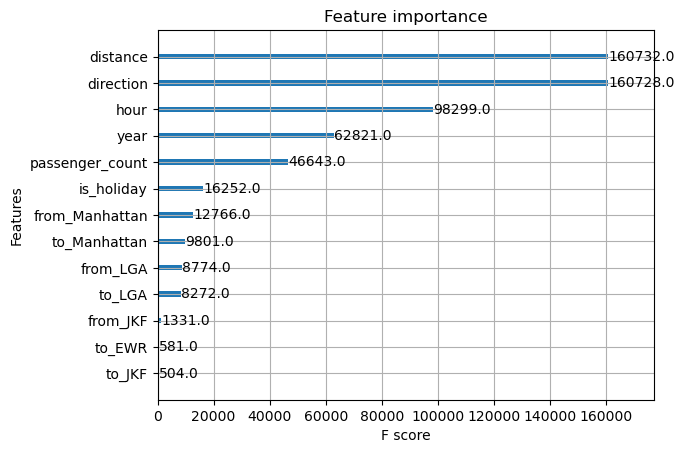

<Figure size 1600x1200 with 0 Axes>

In [9]:
xgb.plot_importance(xgb_reg)
plt.figure(figsize = (16, 12))
plt.show()